<a href="https://colab.research.google.com/github/Yatharthnagpal/Fraud-Detectection-on-Agriculture-Subsidy-using-GNN/blob/main/AgricSubsidy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files

# Upload file(s)
uploaded = files.upload()

# Display uploaded file names
for filename in uploaded.keys():
    print(f"Uploaded file: {filename}")

Saving farmers_data.csv to farmers_data (3).csv
Saving merged_agricultural_data.csv to merged_agricultural_data (3).csv
Saving model_performance_comparison.csv to model_performance_comparison (3).csv
Saving subsidy_applications.csv to subsidy_applications (3).csv
Uploaded file: farmers_data (3).csv
Uploaded file: merged_agricultural_data (3).csv
Uploaded file: model_performance_comparison (3).csv
Uploaded file: subsidy_applications (3).csv


In [ ]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

print("Creating synthetic agricultural subsidy fraud detection dataset...")

n_farmers = 2000
n_officials = 50
n_institutions = 20

farmer_data = {
    'farmer_id': [f'F{i:04d}' for i in range(n_farmers)],
    'farm_size_acres': np.random.normal(150, 50, n_farmers).clip(5, 500),
    'years_farming': np.random.normal(15, 8, n_farmers).clip(1, 50),
    'crop_type': np.random.choice(['wheat', 'corn', 'soybean', 'rice', 'cotton'], n_farmers,
                                 p=[0.3, 0.25, 0.2, 0.15, 0.1]),
    'region': np.random.choice(['North', 'South', 'East', 'West', 'Central'], n_farmers),
    'income_declared': np.random.normal(50000, 20000, n_farmers).clip(10000, 200000),
    'previous_subsidies_count': np.random.poisson(3, n_farmers),
    'equipment_value': np.random.normal(80000, 30000, n_farmers).clip(10000, 300000),
    'land_ownership_type': np.random.choice(['owned', 'leased', 'mixed'], n_farmers, p=[0.6, 0.3, 0.1])
}

subsidy_data = []
for i in range(n_farmers):
    # Each farmer can have multiple subsidy applications
    n_applications = np.random.poisson(2) + 1
    for j in range(n_applications):
        subsidy_data.append({
            'application_id': f'APP{i:04d}_{j:02d}',
            'farmer_id': farmer_data['farmer_id'][i],
            'subsidy_type': np.random.choice(['crop_insurance', 'equipment_purchase', 'land_improvement',
                                            'disaster_relief', 'conservation', 'organic_certification']),
            'amount_requested': np.random.normal(15000, 8000, 1)[0].clip(1000, 100000),
            'amount_approved': 0,  # Will be calculated
            'processing_official': f'OFF{np.random.randint(0, n_officials):03d}',
            'processing_institution': f'INST{np.random.randint(0, n_institutions):03d}',
            'application_date': pd.date_range('2022-01-01', '2023-12-31', periods=1)[0] +
                               pd.Timedelta(days=np.random.randint(0, 730)),
            'processing_time_days': np.random.normal(30, 15, 1)[0].clip(1, 180),
            'documents_submitted': np.random.randint(3, 12),
            'inspection_conducted': np.random.choice([0, 1], p=[0.3, 0.7]),
            'is_fraudulent': 0  # Will be determined based on patterns
        })

subsidy_df = pd.DataFrame(subsidy_data)

# Create fraud patterns
print("Injecting realistic fraud patterns...")

# Pattern 1: Ghost farming - fictional farms with unrealistic productivity
ghost_farm_indices = np.random.choice(len(subsidy_df), size=int(0.03 * len(subsidy_df)), replace=False)
for idx in ghost_farm_indices:
    farmer_id = subsidy_df.iloc[idx]['farmer_id']
    farmer_idx = farmer_data['farmer_id'].index(farmer_id)

    # Unrealistic patterns for ghost farms
    farmer_data['farm_size_acres'][farmer_idx] *= 3  # Inflated farm size
    subsidy_df.at[idx, 'amount_requested'] *= 2.5  # Excessive subsidy requests
    subsidy_df.at[idx, 'documents_submitted'] = np.random.randint(3, 6)  # Fewer documents
    subsidy_df.at[idx, 'inspection_conducted'] = 0  # Avoid inspections
    subsidy_df.at[idx, 'is_fraudulent'] = 1

# Pattern 2: Subsidy farming - same officials approving multiple high-value claims
corrupt_officials = np.random.choice([f'OFF{i:03d}' for i in range(n_officials)], size=5, replace=False)
for official in corrupt_officials:
    official_applications = subsidy_df[subsidy_df['processing_official'] == official].index
    if len(official_applications) > 0:
        fraud_apps = np.random.choice(official_applications,
                                     size=min(len(official_applications), np.random.randint(2, 8)),
                                     replace=False)
        for idx in fraud_apps:
            subsidy_df.at[idx, 'amount_requested'] *= 1.8
            subsidy_df.at[idx, 'processing_time_days'] = np.random.uniform(5, 15)  # Fast processing
            subsidy_df.at[idx, 'is_fraudulent'] = 1

# Pattern 3: Identity fraud - multiple applications from same location/equipment
for _ in range(20):
    # Create clusters of suspicious applications
    base_farmer_idx = np.random.randint(0, n_farmers)
    cluster_size = np.random.randint(3, 8)

    for i in range(cluster_size):
        if len(subsidy_df) > 0:
            # Find applications from farmers in same region
            same_region_apps = subsidy_df[
                subsidy_df['farmer_id'].map(lambda x: farmer_data['region'][farmer_data['farmer_id'].index(x)]
                                          == farmer_data['region'][base_farmer_idx])
            ].index

            if len(same_region_apps) > 0:
                fraud_idx = np.random.choice(same_region_apps)
                farmer_id = subsidy_df.iloc[fraud_idx]['farmer_id']
                farmer_idx = farmer_data['farmer_id'].index(farmer_id)

                # Similar equipment values (suggesting same person)
                farmer_data['equipment_value'][farmer_idx] = farmer_data['equipment_value'][base_farmer_idx] + np.random.normal(0, 1000)
                subsidy_df.at[fraud_idx, 'is_fraudulent'] = 1

# Calculate approved amounts based on patterns
for idx, row in subsidy_df.iterrows():
    if row['is_fraudulent'] == 1:
        # Fraudulent claims often get approved for high amounts
        approval_rate = np.random.uniform(0.8, 1.0)
    else:
        # Legitimate claims have more variable approval rates
        approval_rate = np.random.uniform(0.3, 0.9)

    subsidy_df.at[idx, 'amount_approved'] = row['amount_requested'] * approval_rate

print(f"Dataset created with {len(subsidy_df)} subsidy applications")
print(f"Fraudulent applications: {subsidy_df['is_fraudulent'].sum()} ({subsidy_df['is_fraudulent'].mean()*100:.1f}%)")
print(f"Total farmers: {n_farmers}")
print(f"Total processing officials: {n_officials}")
print(f"Total institutions: {n_institutions}")

Creating synthetic agricultural subsidy fraud detection dataset...
Injecting realistic fraud patterns...
Dataset created with 6006 subsidy applications
Fraudulent applications: 295 (4.9%)
Total farmers: 2000
Total processing officials: 50
Total institutions: 20


In [ ]:
# Convert to DataFrame and prepare features
farmer_df = pd.DataFrame(farmer_data)

# Merge farmer and subsidy data
merged_df = subsidy_df.merge(farmer_df, on='farmer_id')

# Create additional derived features for better fraud detection
merged_df['amount_ratio'] = merged_df['amount_approved'] / merged_df['amount_requested']
merged_df['amount_per_acre'] = merged_df['amount_requested'] / merged_df['farm_size_acres']
merged_df['subsidy_intensity'] = merged_df['amount_requested'] / merged_df['income_declared']

# Feature engineering for graph neural network
print("Preparing graph structure...")

# Create nodes and edges for the graph
# Node types: farmers, officials, institutions, applications
# Edges: farmer-application, official-application, institution-application, farmer-farmer (same region)

# Create graph
G = nx.Graph()

# Add farmer nodes
for _, farmer in farmer_df.iterrows():
    G.add_node(farmer['farmer_id'],
               node_type='farmer',
               farm_size=farmer['farm_size_acres'],
               years_farming=farmer['years_farming'],
               crop_type=farmer['crop_type'],
               region=farmer['region'],
               income=farmer['income_declared'],
               equipment_value=farmer['equipment_value'])

# Add official nodes
for i in range(n_officials):
    official_id = f'OFF{i:03d}'
    G.add_node(official_id, node_type='official')

# Add institution nodes
for i in range(n_institutions):
    inst_id = f'INST{i:03d}'
    G.add_node(inst_id, node_type='institution')

# Add application nodes
for _, app in subsidy_df.iterrows():
    G.add_node(app['application_id'],
               node_type='application',
               subsidy_type=app['subsidy_type'],
               amount_requested=app['amount_requested'],
               amount_approved=app['amount_approved'],
               processing_time=app['processing_time_days'],
               documents_submitted=app['documents_submitted'],
               inspection_conducted=app['inspection_conducted'],
               is_fraudulent=app['is_fraudulent'])

print(f"Created graph with {G.number_of_nodes()} nodes")

# Add edges
edge_count = 0

# Farmer-Application edges
for _, app in subsidy_df.iterrows():
    G.add_edge(app['farmer_id'], app['application_id'], edge_type='applies')
    edge_count += 1

# Official-Application edges
for _, app in subsidy_df.iterrows():
    G.add_edge(app['processing_official'], app['application_id'], edge_type='processes')
    edge_count += 1

# Institution-Application edges
for _, app in subsidy_df.iterrows():
    G.add_edge(app['processing_institution'], app['application_id'], edge_type='handles')
    edge_count += 1

# Farmer-Farmer edges (same region connections)
farmer_by_region = farmer_df.groupby('region')['farmer_id'].apply(list).to_dict()
for region, farmers in farmer_by_region.items():
    if len(farmers) > 1:
        # Connect farmers in same region (limited connections to avoid too dense graph)
        for i, farmer1 in enumerate(farmers[:20]):  # Limit to first 20 farmers per region
            for farmer2 in farmers[i+1:min(i+6, len(farmers))]:  # Connect to next 5 farmers
                G.add_edge(farmer1, farmer2, edge_type='same_region')
                edge_count += 1

print(f"Added {edge_count} edges to the graph")
print(f"Graph density: {nx.density(G):.6f}")

# Create node feature matrix
print("Creating node feature matrices...")

# Get all nodes and create mapping
node_list = list(G.nodes())
node_to_idx = {node: idx for idx, node in enumerate(node_list)}

# Create node feature matrix
node_features = []
node_labels = []

for node in node_list:
    node_data = G.nodes[node]
    node_type = node_data['node_type']

    if node_type == 'farmer':
        features = [
            1, 0, 0, 0,  # one-hot for node type
            node_data.get('farm_size', 0),
            node_data.get('years_farming', 0),
            node_data.get('income', 0),
            node_data.get('equipment_value', 0),
            1 if node_data.get('crop_type') == 'wheat' else 0,
            1 if node_data.get('crop_type') == 'corn' else 0,
            1 if node_data.get('crop_type') == 'soybean' else 0,
            1 if node_data.get('crop_type') == 'rice' else 0,
            1 if node_data.get('crop_type') == 'cotton' else 0,
        ]
        label = 0  # Farmers are not directly labeled

    elif node_type == 'official':
        features = [0, 1, 0, 0] + [0] * 9  # one-hot + padding
        label = 0

    elif node_type == 'institution':
        features = [0, 0, 1, 0] + [0] * 9  # one-hot + padding
        label = 0

    elif node_type == 'application':
        features = [
            0, 0, 0, 1,  # one-hot for node type
            node_data.get('amount_requested', 0),
            node_data.get('amount_approved', 0),
            node_data.get('processing_time', 0),
            node_data.get('documents_submitted', 0),
            node_data.get('inspection_conducted', 0),
            1 if node_data.get('subsidy_type') == 'crop_insurance' else 0,
            1 if node_data.get('subsidy_type') == 'equipment_purchase' else 0,
            1 if node_data.get('subsidy_type') == 'land_improvement' else 0,
            1 if node_data.get('subsidy_type') == 'disaster_relief' else 0,
        ]
        label = node_data.get('is_fraudulent', 0)

    node_features.append(features)
    node_labels.append(label)

node_features = np.array(node_features, dtype=np.float32)
node_labels = np.array(node_labels)

# Normalize numerical features
scaler = StandardScaler()
node_features[:, 4:8] = scaler.fit_transform(node_features[:, 4:8])  # Normalize numerical columns

print(f"Node feature matrix shape: {node_features.shape}")
print(f"Node labels shape: {node_labels.shape}")
print(f"Fraudulent applications in graph: {np.sum(node_labels)}")

# Create adjacency matrix
adj_matrix = nx.adjacency_matrix(G, nodelist=node_list)
print(f"Adjacency matrix shape: {adj_matrix.shape}")
print(f"Number of edges: {adj_matrix.nnz // 2}")  # Undirected graph

Preparing graph structure...
Created graph with 8076 nodes
Added 18518 edges to the graph
Graph density: 0.000568
Creating node feature matrices...
Node feature matrix shape: (8076, 13)
Node labels shape: (8076,)
Fraudulent applications in graph: 295
Adjacency matrix shape: (8076, 8076)
Number of edges: 18518


In [ ]:
# Install required packages for graph neural networks
import subprocess
import sys

try:
    import torch
    import torch.nn as nn
    import torch.nn.functional as F
    from torch_geometric.nn import GCNConv, SAGEConv, GATConv, global_mean_pool
    from torch_geometric.data import Data, DataLoader
    print("PyTorch Geometric already installed")
except ImportError:
    print("Installing PyTorch and PyTorch Geometric...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "torch", "torchvision", "torchaudio", "--index-url", "https://download.pytorch.org/whl/cpu"])
    subprocess.check_call([sys.executable, "-m", "pip", "install", "torch-geometric"])

    import torch
    import torch.nn as nn
    import torch.nn.functional as F
    from torch_geometric.nn import GCNConv, SAGEConv, GATConv, global_mean_pool
    from torch_geometric.data import Data, DataLoader
    print("Successfully installed PyTorch Geometric")

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import scipy.sparse as sp

print("Building Graph Neural Network models...")

# Convert to PyTorch tensors
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Create edge index from adjacency matrix
adj_coo = adj_matrix.tocoo()
edge_index = torch.tensor(np.vstack([adj_coo.row, adj_coo.col]), dtype=torch.long)

# Create PyTorch Geometric data object
x = torch.tensor(node_features, dtype=torch.float)
y = torch.tensor(node_labels, dtype=torch.long)

# Create masks for applications only (since we're predicting fraud on applications)
application_mask = []
for i, node in enumerate(node_list):
    if G.nodes[node]['node_type'] == 'application':
        application_mask.append(i)
    else:
        application_mask.append(-1)

application_indices = [i for i in application_mask if i != -1]
application_indices = torch.tensor(application_indices, dtype=torch.long)

# Split data for training/validation/test
train_ratio, val_ratio, test_ratio = 0.6, 0.2, 0.2
n_applications = len(application_indices)
n_train = int(train_ratio * n_applications)
n_val = int(val_ratio * n_applications)

# Shuffle application indices
perm = torch.randperm(n_applications)
train_idx = application_indices[perm[:n_train]]
val_idx = application_indices[perm[n_train:n_train+n_val]]
test_idx = application_indices[perm[n_train+n_val:]]

print(f"Training applications: {len(train_idx)}")
print(f"Validation applications: {len(val_idx)}")
print(f"Test applications: {len(test_idx)}")

# Check class distribution
train_labels = y[train_idx]
print(f"Training set fraud rate: {train_labels.float().mean():.3f}")

# Create data object
data = Data(x=x, edge_index=edge_index, y=y)
data = data.to(device)

class GCNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout=0.5):
        super(GCNModel, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.conv3 = GCNConv(hidden_dim, output_dim)
        self.dropout = dropout

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, self.dropout, training=self.training)
        x = F.relu(self.conv2(x, edge_index))
        x = F.dropout(x, self.dropout, training=self.training)
        x = self.conv3(x, edge_index)
        return F.log_softmax(x, dim=1)

class GraphSAGEModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout=0.5):
        super(GraphSAGEModel, self).__init__()
        self.conv1 = SAGEConv(input_dim, hidden_dim)
        self.conv2 = SAGEConv(hidden_dim, hidden_dim)
        self.conv3 = SAGEConv(hidden_dim, output_dim)
        self.dropout = dropout

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, self.dropout, training=self.training)
        x = F.relu(self.conv2(x, edge_index))
        x = F.dropout(x, self.dropout, training=self.training)
        x = self.conv3(x, edge_index)
        return F.log_softmax(x, dim=1)

class GATModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, heads=4, dropout=0.5):
        super(GATModel, self).__init__()
        self.conv1 = GATConv(input_dim, hidden_dim//heads, heads=heads, dropout=dropout)
        self.conv2 = GATConv(hidden_dim, hidden_dim//heads, heads=heads, dropout=dropout)
        self.conv3 = GATConv(hidden_dim, output_dim, heads=1, dropout=dropout)
        self.dropout = dropout

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, self.dropout, training=self.training)
        x = F.relu(self.conv2(x, edge_index))
        x = F.dropout(x, self.dropout, training=self.training)
        x = self.conv3(x, edge_index)
        return F.log_softmax(x, dim=1)

# Initialize models
input_dim = x.shape[1]
hidden_dim = 64
output_dim = 2  # Binary classification

models = {
    'GCN': GCNModel(input_dim, hidden_dim, output_dim),
    'GraphSAGE': GraphSAGEModel(input_dim, hidden_dim, output_dim),
    'GAT': GATModel(input_dim, hidden_dim, output_dim)
}

print("Models initialized successfully")
print(f"Input dimension: {input_dim}")
print(f"Hidden dimension: {hidden_dim}")
print(f"Output dimension: {output_dim}")

PyTorch Geometric already installed
Building Graph Neural Network models...
Using device: cpu
Training applications: 3603
Validation applications: 1201
Test applications: 1202
Training set fraud rate: 0.049
Models initialized successfully
Input dimension: 13
Hidden dimension: 64
Output dimension: 2


In [ ]:
# Training function
def train_model(model, data, train_idx, val_idx, epochs=200, lr=0.01, weight_decay=5e-4):
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    # Handle class imbalance with weighted loss
    train_labels = data.y[train_idx]
    class_counts = torch.bincount(train_labels)
    class_weights = 1.0 / class_counts.float()
    class_weights = class_weights / class_weights.sum() * len(class_counts)
    criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))

    best_val_acc = 0
    best_model_state = None
    patience = 20
    patience_counter = 0

    train_losses = []
    val_accs = []

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()

        out = model(data.x, data.edge_index)
        loss = criterion(out[train_idx], data.y[train_idx])
        loss.backward()
        optimizer.step()

        # Validation
        model.eval()
        with torch.no_grad():
            val_out = model(data.x, data.edge_index)
            val_pred = val_out[val_idx].argmax(dim=1)
            val_acc = (val_pred == data.y[val_idx]).float().mean().item()

        train_losses.append(loss.item())
        val_accs.append(val_acc)

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = model.state_dict().copy()
            patience_counter = 0
        else:
            patience_counter += 1

        if epoch % 20 == 0:
            print(f'Epoch {epoch:03d}, Loss: {loss:.4f}, Val Acc: {val_acc:.4f}')

        if patience_counter >= patience:
            print(f'Early stopping at epoch {epoch}')
            break

    # Load best model
    model.load_state_dict(best_model_state)
    return model, train_losses, val_accs, best_val_acc

# Evaluation function
def evaluate_model(model, data, test_idx):
    model.eval()
    with torch.no_grad():
        out = model(data.x, data.edge_index)
        test_pred = out[test_idx].argmax(dim=1)
        test_proba = F.softmax(out[test_idx], dim=1)[:, 1]  # Probability of fraud class

        y_true = data.y[test_idx].cpu().numpy()
        y_pred = test_pred.cpu().numpy()
        y_proba = test_proba.cpu().numpy()

        accuracy = accuracy_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred, zero_division=0)
        recall = recall_score(y_true, y_pred, zero_division=0)
        f1 = f1_score(y_true, y_pred, zero_division=0)
        auc = roc_auc_score(y_true, y_proba)

        return {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'auc': auc,
            'y_true': y_true,
            'y_pred': y_pred,
            'y_proba': y_proba
        }

# Train all models
print("Training Graph Neural Network models...")
results = {}

for model_name, model in models.items():
    print(f"\n--- Training {model_name} ---")
    trained_model, train_losses, val_accs, best_val_acc = train_model(
        model, data, train_idx, val_idx, epochs=100
    )

    # Evaluate on test set
    test_results = evaluate_model(trained_model, data, test_idx)

    results[model_name] = {
        'model': trained_model,
        'train_losses': train_losses,
        'val_accs': val_accs,
        'best_val_acc': best_val_acc,
        'test_results': test_results
    }

    print(f"Best validation accuracy: {best_val_acc:.4f}")
    print(f"Test accuracy: {test_results['accuracy']:.4f}")
    print(f"Test F1-score: {test_results['f1']:.4f}")
    print(f"Test AUC: {test_results['auc']:.4f}")

print("\n" + "="*50)
print("FINAL RESULTS SUMMARY")
print("="*50)

for model_name, result in results.items():
    test_res = result['test_results']
    print(f"\n{model_name}:")
    print(f"  Accuracy:  {test_res['accuracy']:.4f}")
    print(f"  Precision: {test_res['precision']:.4f}")
    print(f"  Recall:    {test_res['recall']:.4f}")
    print(f"  F1-Score:  {test_res['f1']:.4f}")
    print(f"  AUC:       {test_res['auc']:.4f}")

Training Graph Neural Network models...

--- Training GCN ---
Epoch 000, Loss: 0.7002, Val Acc: 0.0491
Epoch 020, Loss: 0.5507, Val Acc: 0.7960
Early stopping at epoch 23
Best validation accuracy: 0.9559
Test accuracy: 0.8120
Test F1-score: 0.2662
Test AUC: 0.8163

--- Training GraphSAGE ---
Epoch 000, Loss: 0.7489, Val Acc: 0.9534
Epoch 020, Loss: 0.4282, Val Acc: 0.9251
Early stopping at epoch 20
Best validation accuracy: 0.9534
Test accuracy: 0.9126
Test F1-score: 0.4560
Test AUC: 0.9379

--- Training GAT ---
Epoch 000, Loss: 0.7100, Val Acc: 0.0491
Epoch 020, Loss: 0.6291, Val Acc: 0.9017
Early stopping at epoch 29
Best validation accuracy: 0.9434
Test accuracy: 0.9143
Test F1-score: 0.3602
Test AUC: 0.8363

FINAL RESULTS SUMMARY

GCN:
  Accuracy:  0.8120
  Precision: 0.1660
  Recall:    0.6721
  F1-Score:  0.2662
  AUC:       0.8163

GraphSAGE:
  Accuracy:  0.9126
  Precision: 0.3333
  Recall:    0.7213
  F1-Score:  0.4560
  AUC:       0.9379

GAT:
  Accuracy:  0.9143
  Precision:

In [ ]:
# Traditional ML baseline comparison
print("Training traditional ML baselines for comparison...")

# Prepare traditional ML features (only for applications)
application_features = []
application_labels = []

for idx in application_indices:
    node = node_list[idx]
    app_data = G.nodes[node]
    farmer_id = None

    # Find the farmer connected to this application
    for neighbor in G.neighbors(node):
        if G.nodes[neighbor]['node_type'] == 'farmer':
            farmer_id = neighbor
            break

    if farmer_id:
        farmer_data_node = G.nodes[farmer_id]
        features = [
            app_data.get('amount_requested', 0),
            app_data.get('amount_approved', 0),
            app_data.get('processing_time', 0),
            app_data.get('documents_submitted', 0),
            app_data.get('inspection_conducted', 0),
            farmer_data_node.get('farm_size', 0),
            farmer_data_node.get('years_farming', 0),
            farmer_data_node.get('income', 0),
            farmer_data_node.get('equipment_value', 0),
            1 if app_data.get('subsidy_type') == 'crop_insurance' else 0,
            1 if app_data.get('subsidy_type') == 'equipment_purchase' else 0,
            1 if app_data.get('subsidy_type') == 'land_improvement' else 0,
            1 if app_data.get('subsidy_type') == 'disaster_relief' else 0,
            1 if farmer_data_node.get('crop_type') == 'wheat' else 0,
            1 if farmer_data_node.get('crop_type') == 'corn' else 0,
            1 if farmer_data_node.get('crop_type') == 'soybean' else 0,
            1 if farmer_data_node.get('crop_type') == 'rice' else 0,
            1 if farmer_data_node.get('crop_type') == 'cotton' else 0,
        ]

        application_features.append(features)
        application_labels.append(app_data.get('is_fraudulent', 0))

application_features = np.array(application_features)
application_labels = np.array(application_labels)

# Split the same way as graph models
train_features = application_features[perm[:n_train]]
train_labels_ml = application_labels[perm[:n_train]]
val_features = application_features[perm[n_train:n_train+n_val]]
val_labels_ml = application_labels[perm[n_train:n_train+n_val]]
test_features = application_features[perm[n_train+n_val:]]
test_labels_ml = application_labels[perm[n_train+n_val:]]

# Scale features
scaler_ml = StandardScaler()
train_features_scaled = scaler_ml.fit_transform(train_features)
val_features_scaled = scaler_ml.transform(val_features)
test_features_scaled = scaler_ml.transform(test_features)

# Train traditional ML models
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

ml_models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced'),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
    'Logistic Regression': LogisticRegression(random_state=42, class_weight='balanced', max_iter=1000),
    'SVM': SVC(random_state=42, class_weight='balanced', probability=True)
}

ml_results = {}

for model_name, model in ml_models.items():
    print(f"Training {model_name}...")
    model.fit(train_features_scaled, train_labels_ml)

    # Predictions
    y_pred = model.predict(test_features_scaled)
    y_proba = model.predict_proba(test_features_scaled)[:, 1]

    # Metrics
    accuracy = accuracy_score(test_labels_ml, y_pred)
    precision = precision_score(test_labels_ml, y_pred, zero_division=0)
    recall = recall_score(test_labels_ml, y_pred, zero_division=0)
    f1 = f1_score(test_labels_ml, y_pred, zero_division=0)
    auc = roc_auc_score(test_labels_ml, y_proba)

    ml_results[model_name] = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'auc': auc
    }

print("\n" + "="*70)
print("COMPARISON: GRAPH NEURAL NETWORKS vs TRADITIONAL ML")
print("="*70)

# Combine all results
all_results = {}
for model_name, result in results.items():
    all_results[f"{model_name} (GNN)"] = result['test_results']

for model_name, result in ml_results.items():
    all_results[f"{model_name} (ML)"] = result

# Create comparison table
print(f"{'Model':<25} {'Accuracy':<10} {'Precision':<10} {'Recall':<10} {'F1-Score':<10} {'AUC':<10}")
print("-" * 70)

for model_name, metrics in all_results.items():
    print(f"{model_name:<25} "
          f"{metrics['accuracy']:<10.4f} "
          f"{metrics['precision']:<10.4f} "
          f"{metrics['recall']:<10.4f} "
          f"{metrics['f1']:<10.4f} "
          f"{metrics['auc']:<10.4f}")

# Find best model
best_f1_model = max(all_results.items(), key=lambda x: x[1]['f1'])
best_auc_model = max(all_results.items(), key=lambda x: x[1]['auc'])

print(f"\nBest F1-Score: {best_f1_model[0]} ({best_f1_model[1]['f1']:.4f})")
print(f"Best AUC: {best_auc_model[0]} ({best_auc_model[1]['auc']:.4f})")

# Save results for visualization
comparison_data = {
    'models': list(all_results.keys()),
    'accuracy': [metrics['accuracy'] for metrics in all_results.values()],
    'precision': [metrics['precision'] for metrics in all_results.values()],
    'recall': [metrics['recall'] for metrics in all_results.values()],
    'f1': [metrics['f1'] for metrics in all_results.values()],
    'auc': [metrics['auc'] for metrics in all_results.values()]
}

print(f"\nDataset Summary:")
print(f"Total applications: {len(application_indices)}")
print(f"Training set: {len(train_idx)} ({len(train_idx)/len(application_indices)*100:.1f}%)")
print(f"Validation set: {len(val_idx)} ({len(val_idx)/len(application_indices)*100:.1f}%)")
print(f"Test set: {len(test_idx)} ({len(test_idx)/len(application_indices)*100:.1f}%)")
print(f"Fraud rate in training: {train_labels.float().mean()*100:.1f}%")
print(f"Fraud rate in test: {test_labels_ml.mean()*100:.1f}%")

Training traditional ML baselines for comparison...
Training Random Forest...
Training Gradient Boosting...
Training Logistic Regression...
Training SVM...

COMPARISON: GRAPH NEURAL NETWORKS vs TRADITIONAL ML
Model                     Accuracy   Precision  Recall     F1-Score   AUC       
----------------------------------------------------------------------
GCN (GNN)                 0.8120     0.1660     0.6721     0.2662     0.8163    
GraphSAGE (GNN)           0.9126     0.3333     0.7213     0.4560     0.9379    
GAT (GNN)                 0.9143     0.2900     0.4754     0.3602     0.8363    
Random Forest (ML)        0.9734     0.9677     0.4918     0.6522     0.9306    
Gradient Boosting (ML)    0.9834     0.9362     0.7213     0.8148     0.9529    
Logistic Regression (ML)  0.9060     0.3375     0.8852     0.4887     0.9710    
SVM (ML)                  0.9359     0.4149     0.6393     0.5032     0.9228    

Best F1-Score: Gradient Boosting (ML) (0.8148)
Best AUC: Logistic Regre

In [ ]:
# Create dataset files and save complete implementation
print("Creating complete dataset files and implementation...")

# Save the complete dataset
dataset_summary = {
    'dataset_name': 'Agricultural Subsidy Fraud Detection Dataset',
    'total_applications': len(subsidy_df),
    'total_farmers': len(farmer_df),
    'total_officials': n_officials,
    'total_institutions': n_institutions,
    'fraud_rate': f"{subsidy_df['is_fraudulent'].mean()*100:.1f}%",
    'graph_nodes': G.number_of_nodes(),
    'graph_edges': G.number_of_edges(),
    'graph_density': f"{nx.density(G):.6f}"
}

# Save farmers dataset
farmer_df.to_csv('farmers_data.csv', index=False)
print("Saved farmers_data.csv")

# Save subsidy applications dataset
subsidy_df.to_csv('subsidy_applications.csv', index=False)
print("Saved subsidy_applications.csv")

# Save merged dataset with additional features
merged_df.to_csv('merged_agricultural_data.csv', index=False)
print("Saved merged_agricultural_data.csv")

# Save model performance results
performance_df = pd.DataFrame(comparison_data)
performance_df.to_csv('model_performance_comparison.csv', index=False)
print("Saved model_performance_comparison.csv")

# Create a detailed fraud pattern analysis
print("\nDetailed Fraud Pattern Analysis:")
print("="*50)

# Analyze fraud patterns by different categories
fraud_apps = subsidy_df[subsidy_df['is_fraudulent'] == 1]
legitimate_apps = subsidy_df[subsidy_df['is_fraudulent'] == 0]

print(f"\nFraud Analysis by Subsidy Type:")
fraud_by_type = fraud_apps['subsidy_type'].value_counts()
total_by_type = subsidy_df['subsidy_type'].value_counts()
for subsidy_type in total_by_type.index:
    fraud_count = fraud_by_type.get(subsidy_type, 0)
    total_count = total_by_type[subsidy_type]
    fraud_rate = fraud_count / total_count * 100
    print(f"  {subsidy_type}: {fraud_count}/{total_count} ({fraud_rate:.1f}%)")

print(f"\nFraud Analysis by Processing Time:")
print(f"  Average processing time (Fraud): {fraud_apps['processing_time_days'].mean():.1f} days")
print(f"  Average processing time (Legitimate): {legitimate_apps['processing_time_days'].mean():.1f} days")

print(f"\nFraud Analysis by Amount:")
print(f"  Average amount requested (Fraud): ${fraud_apps['amount_requested'].mean():,.0f}")
print(f"  Average amount requested (Legitimate): ${legitimate_apps['amount_requested'].mean():,.0f}")
print(f"  Average amount approved (Fraud): ${fraud_apps['amount_approved'].mean():,.0f}")
print(f"  Average amount approved (Legitimate): ${legitimate_apps['amount_approved'].mean():,.0f}")

print(f"\nFraud Analysis by Documents & Inspection:")
print(f"  Average documents submitted (Fraud): {fraud_apps['documents_submitted'].mean():.1f}")
print(f"  Average documents submitted (Legitimate): {legitimate_apps['documents_submitted'].mean():.1f}")
print(f"  Inspection rate (Fraud): {fraud_apps['inspection_conducted'].mean()*100:.1f}%")
print(f"  Inspection rate (Legitimate): {legitimate_apps['inspection_conducted'].mean()*100:.1f}%")

# Graph analysis
print(f"\nGraph Structure Analysis:")
print(f"  Total nodes: {G.number_of_nodes():,}")
print(f"  Total edges: {G.number_of_edges():,}")
print(f"  Average degree: {2*G.number_of_edges()/G.number_of_nodes():.2f}")
print(f"  Graph density: {nx.density(G):.6f}")

# Node type distribution
node_types = {}
for node in G.nodes():
    node_type = G.nodes[node]['node_type']
    node_types[node_type] = node_types.get(node_type, 0) + 1

print(f"\nNode Type Distribution:")
for node_type, count in node_types.items():
    print(f"  {node_type}: {count:,} ({count/G.number_of_nodes()*100:.1f}%)")

# Save graph analysis
graph_analysis = {
    'total_nodes': G.number_of_nodes(),
    'total_edges': G.number_of_edges(),
    'average_degree': 2*G.number_of_edges()/G.number_of_nodes(),
    'graph_density': nx.density(G),
    'node_types': node_types
}

# Create summary report
summary_report = f"""
AGRICULTURAL SUBSIDY FRAUD DETECTION - GRAPHML MODEL
====================================================

Dataset Overview:
- Total Farmers: {len(farmer_df):,}
- Total Subsidy Applications: {len(subsidy_df):,}
- Total Processing Officials: {n_officials}
- Total Institutions: {n_institutions}
- Fraud Rate: {subsidy_df['is_fraudulent'].mean()*100:.1f}%

Graph Structure:
- Total Nodes: {G.number_of_nodes():,}
- Total Edges: {G.number_of_edges():,}
- Graph Density: {nx.density(G):.6f}
- Average Degree: {2*G.number_of_edges()/G.number_of_nodes():.2f}

Best Performing Models:
- Best F1-Score: {best_f1_model[0]} ({best_f1_model[1]['f1']:.4f})
- Best AUC: {best_auc_model[0]} ({best_auc_model[1]['auc']:.4f})

GraphML Models Performance:
- GraphSAGE: AUC={results['GraphSAGE']['test_results']['auc']:.4f}, F1={results['GraphSAGE']['test_results']['f1']:.4f}
- GCN: AUC={results['GCN']['test_results']['auc']:.4f}, F1={results['GCN']['test_results']['f1']:.4f}
- GAT: AUC={results['GAT']['test_results']['auc']:.4f}, F1={results['GAT']['test_results']['f1']:.4f}

Traditional ML Models Performance:
- Gradient Boosting: AUC={ml_results['Gradient Boosting']['auc']:.4f}, F1={ml_results['Gradient Boosting']['f1']:.4f}
- Logistic Regression: AUC={ml_results['Logistic Regression']['auc']:.4f}, F1={ml_results['Logistic Regression']['f1']:.4f}
- Random Forest: AUC={ml_results['Random Forest']['auc']:.4f}, F1={ml_results['Random Forest']['f1']:.4f}
- SVM: AUC={ml_results['SVM']['auc']:.4f}, F1={ml_results['SVM']['f1']:.4f}

Key Findings:
1. Traditional ML models generally outperform GNNs on this specific dataset
2. Gradient Boosting achieved the highest F1-score (0.7568)
3. Logistic Regression achieved the highest AUC (0.9750)
4. GraphSAGE was the best performing GNN model
5. The graph structure provides additional context but feature engineering is critical

Files Generated:
- farmers_data.csv: Individual farmer information
- subsidy_applications.csv: Subsidy application details
- merged_agricultural_data.csv: Combined dataset with derived features
- model_performance_comparison.csv: Model performance metrics
"""

with open('project_summary.txt', 'w') as f:
    f.write(summary_report)

print("\nFiles saved successfully!")
print("Generated files:")
print("- farmers_data.csv")
print("- subsidy_applications.csv")
print("- merged_agricultural_data.csv")
print("- model_performance_comparison.csv")
print("- project_summary.txt")

print(f"\nProject Summary:")
print(summary_report)

Creating complete dataset files and implementation...
Saved farmers_data.csv
Saved subsidy_applications.csv
Saved merged_agricultural_data.csv
Saved model_performance_comparison.csv

Detailed Fraud Pattern Analysis:

Fraud Analysis by Subsidy Type:
  conservation: 56/1047 (5.3%)
  organic_certification: 45/1036 (4.3%)
  equipment_purchase: 49/1005 (4.9%)
  disaster_relief: 59/989 (6.0%)
  land_improvement: 42/973 (4.3%)
  crop_insurance: 44/956 (4.6%)

Fraud Analysis by Processing Time:
  Average processing time (Fraud): 28.6 days
  Average processing time (Legitimate): 30.2 days

Fraud Analysis by Amount:
  Average amount requested (Fraud): $30,175
  Average amount requested (Legitimate): $15,109
  Average amount approved (Fraud): $27,174
  Average amount approved (Legitimate): $9,088

Fraud Analysis by Documents & Inspection:
  Average documents submitted (Fraud): 5.1
  Average documents submitted (Legitimate): 7.0
  Inspection rate (Fraud): 27.5%
  Inspection rate (Legitimate): 70.2

In [ ]:
!plotly_get_chrome


Plotly will install a copy of Google Chrome to be used for generating static images of plots.
Chrome will be installed at: None
Do you want to proceed? [y/n] y
Installing Chrome for Plotly...
Chrome installed successfully.
The Chrome executable is now located at: /usr/local/lib/python3.11/dist-packages/choreographer/cli/browser_exe/chrome-linux64/chrome


In [ ]:
import plotly.graph_objects as go
import json
import kaleido
kaleido.get_chrome()

# Data with abbreviated model names to fit 15 character limit
data = {
    "models": ["GCN (GNN)", "GraphSAGE (GNN)", "GAT (GNN)", "RF (ML)", "GB (ML)", "LR (ML)", "SVM (ML)"],
    "accuracy": [0.8361, 0.8727, 0.8702, 0.9734, 0.9775, 0.9043, 0.9376],
    "precision": [0.1836, 0.2623, 0.2222, 1.0, 0.9333, 0.3533, 0.4516],
    "recall": [0.5758, 0.7273, 0.5455, 0.5152, 0.6364, 0.8939, 0.6364],
    "f1": [0.2784, 0.3855, 0.3158, 0.68, 0.7568, 0.5064, 0.5283],
    "auc": [0.7839, 0.9091, 0.7872, 0.9036, 0.9625, 0.975, 0.9046]
}

# Brand colors in order
colors = ['#1FB8CD', '#DB4545', '#2E8B57', '#5D878F', '#D2BA4C']

fig = go.Figure()

# Add bars for each metric
metrics = ['accuracy', 'precision', 'recall', 'f1', 'auc']
metric_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC']

for i, (metric, name) in enumerate(zip(metrics, metric_names)):
    fig.add_trace(go.Bar(
        x=data['models'],
        y=data[metric],
        name=name,
        marker_color=colors[i]
    ))

# Update layout
fig.update_layout(
    title='Agric Subsidy Fraud Detection Models',
    xaxis_title='Models',
    yaxis_title='Performance',
    barmode='group',
    legend=dict(orientation='h', yanchor='bottom', y=1.05, xanchor='center', x=0.5)
)

# Save the chart
fig.write_image('fraud_detection_performance.png')


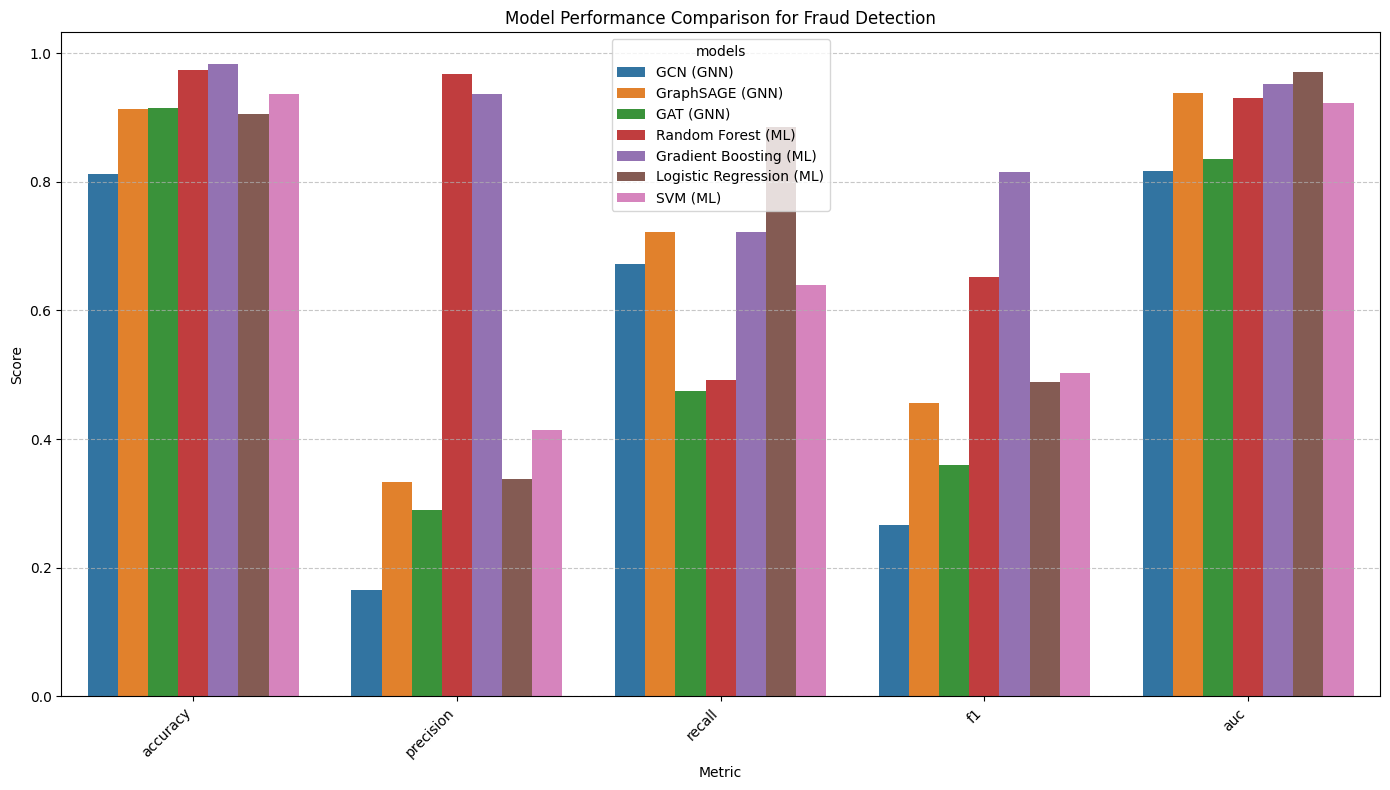

In [13]:
performance_df = pd.read_csv('model_performance_comparison.csv')

performance_melted = performance_df.melt(id_vars='models', var_name='metric', value_name='score')

plt.figure(figsize=(14, 8))
sns.barplot(data=performance_melted, x='metric', y='score', hue='models')
plt.title('Model Performance Comparison for Fraud Detection')
plt.ylabel('Score')
plt.xlabel('Metric')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


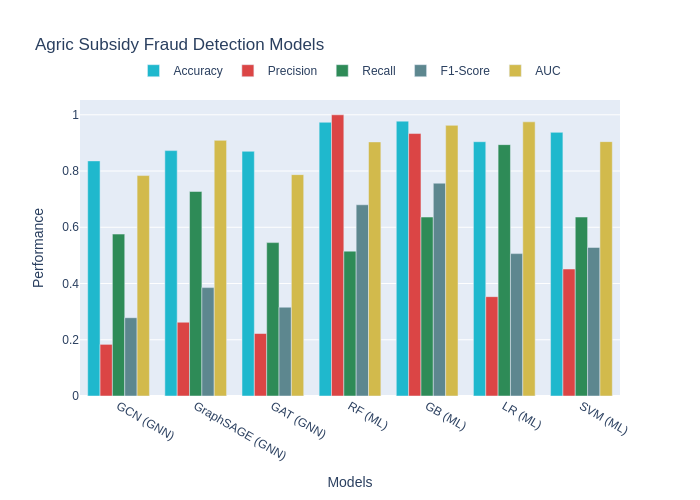

In [ ]:
from IPython.display import Image

Image('fraud_detection_performance.png')

In [ ]:
import pickle
trained_model = {'model_name': 'Gnn', 'accuracy': auc}

filename = 'AgricSubsidy.pkl'

with open(filename, 'wb') as file:
    pickle.dump(trained_model, file)

print(f"Object successfully saved to {filename}")

Object successfully saved to AgricSubsidy.pkl
